## **파이썬 딥러닝 텐서플로 CH4. 합성곱 신경망(CNN)**

0620 월요일 과제 [개념+필사]

### **01 합성곱 신경망**

데이터가 가진 특징들의 패턴을 학습하는 알고리즘. 
* 이미지 분류
* 객체 탐지
* 스타일 전이

#### **1-1** 이미지 표현

* 이미지를 숫자로 표현

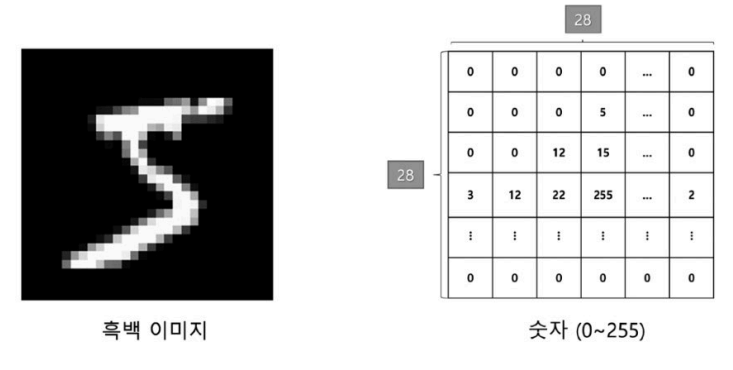

* 숫자로 각 픽셀의 화소 값을 나타냄.
    * 0: 검은 색, 255: 흰색

* 컬러 이미지로 표현

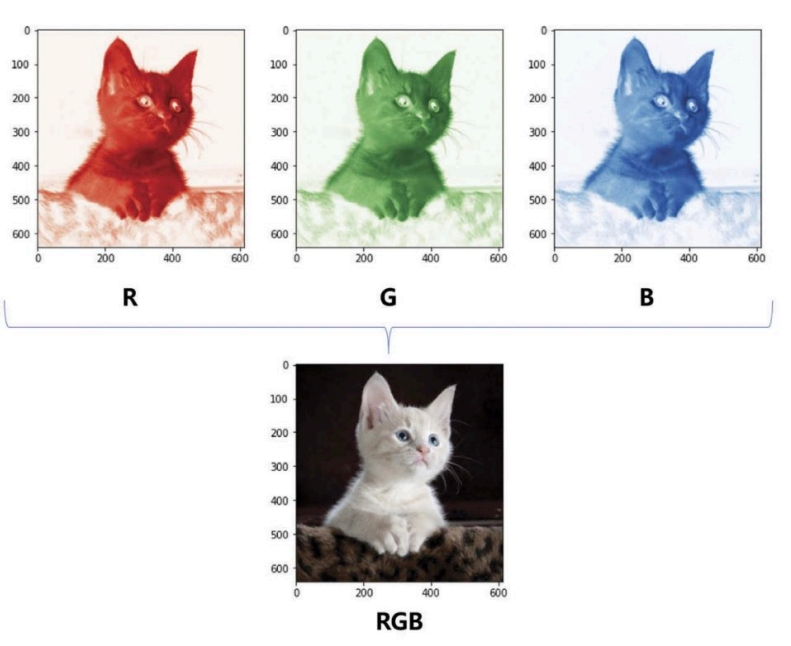

#### **1-2** 합성곱(Convolution)

입력 이미지에 대하여 일반적으로 정방형 크기를 가지는 **커널**을 사용하여 입력 이미지에 대한 특성을 추출하는 방법.
* **특성맵(feature map)**: 합성곱 연산을 통해서 추출된 이미지

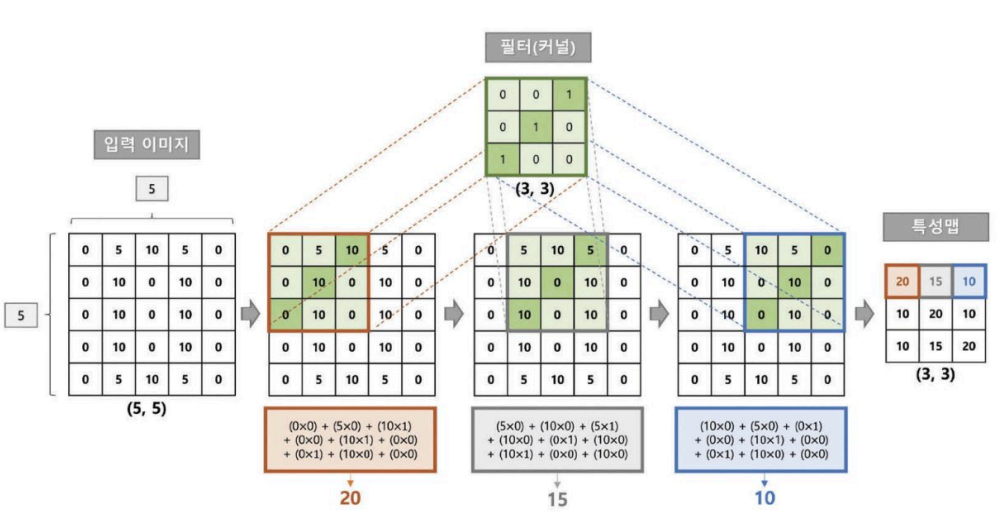

#### **1-3** 채널(channel)

입력 이미지를 구성하는 2차원 배열의 개수
* 입력 이미지가 여러 개의 채널을 갖는 경우, 합성곱 연산을 수행할 때 특성맵의 생성과정을 잘 살펴야 한다.
    * 입력 이미지의 채널 개수만큼 커널 생성
    * 각 채널마다 하나씩 커널 적용하여 합성곱 연산 수행
    * 입력 이미지의 채널 개수만큼 합성곱 연산된 결과가 생성되고, element-wise 덧셈 연산으로 모두 더해 최종 특성맵 생성

#### **1-4** 스트라이드(stride)

커널은 좌측 상단으로부터 입력 이미지를 기준으로 우측으로 이동하며 합성곱 연산을 수행하고 특성맵에 결과를 채워나가는데, 이때 이동하는 간격을 의미. 주로 1 or 2로 설정.

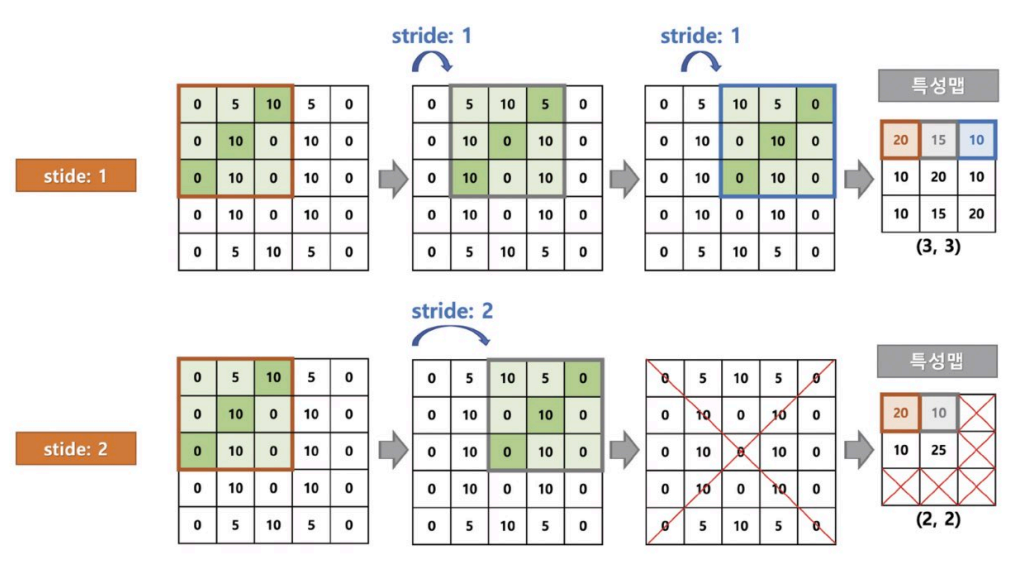

* 텐서플로 케라스의 Conv2D 레이어의 strides 매개변수로 지정.

#### **1-5** 패딩(padding)

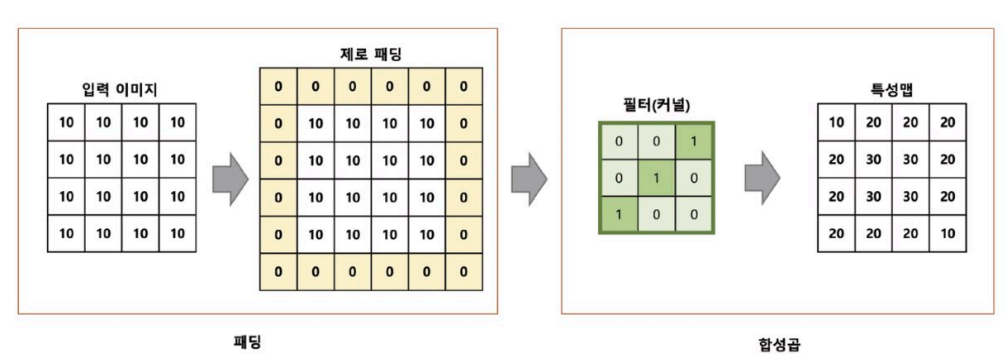

* 특성맵의 사이즈가 줄어들 때 추출된 특성맵의 크기가 입력 이미지 대비 줄어들지 않도록 설정하는 장치. 
* 일반적으로 zero-padding을 사용. (0입력 이미지의 가장 자리에 0으로)
    * 텐서플로 케라스의 Covn2D 레이어에서 padding = 'same'

#### **1-6** 특성맵(feature map) 사이즈

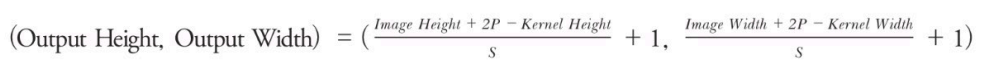

* Image Height, Image Width: 입력 크기
* Kernel Height, Kernel Width: 필터 크기
* S: 스트라이드(strides)
* P: 패딩(padding)
* Output Height, Output Width: 출력 크기

#### **1-7** 풀링(pooling)

* 추출된 특성맵에 대해 다운 샘플링하여 이미지의 크기를 축소하는 레이어.
* 이미지 축소를 통해 연산량을 감소시키고 과대적합 방지 가능.

* 최대 풀링(max pooling): 특징의 값이 큰 값이 다른 특징 대표. 합성곱 신경망과 같이 주로 사용됨.
* 평균 풀링(average pooling): 픽셀들의 평균 값.

### **02 간단한 모델 생성**

#### **2-1** 데이터 로드 및 전처리

In [ ]:
# tensorflow 모듈 import
import tensorflow as tf

In [ ]:
# mnist 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


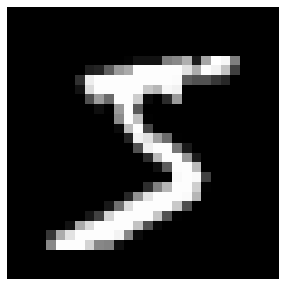

In [ ]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data,idx):
    plt.figure(figsize=(5,5))
    plt.imshow(data[idx], cmap='gray')
    plt.axis('off')
    plt.show()

plot_image(x_train, 0)

In [ ]:
print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0 255
0 255


In [ ]:
# 정규화
x_train = x_train / 255.0
x_valid = x_valid / 255.0

print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0.0 1.0
0.0 1.0


In [ ]:
# 채널 추가
print(x_train.shape, x_valid.shape)

x_train_in = x_train[..., tf.newaxis]
x_valid_in = x_valid[..., tf.newaxis]

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


#### **2-2** Sequential API로 모델 생성 및 학습

* Sequential API를 사용해 합성곱 레이어1, 풀링 레이어1 적용
* 최종 분류기로 Dense레이어 적용 -> Flatten 층을 추가하여 1차원 배열로 펼침.
* 합성곱은 Conv2D, (3,3) 크기의 서로 다른 32가지 종류의 커널 적용
* ReLU 활성화 함수 적용
* name 속성에 레이어 이름은 'conv'
* 풀링 레이어는 (2,2)로 최대 풀링 적용.
* 레이어 이름 속성 추가.
* 최종 분류기는 10개의 값을 가짐. 활성화 함수는 softmax 사용.

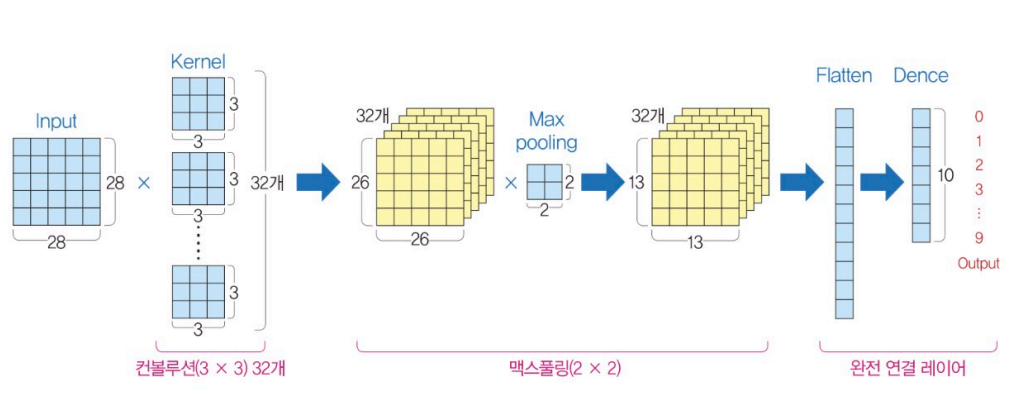

In [ ]:
# Sequential API를 사용해 샘플 모델 생성
model = tf.keras.Sequential([
    # Convolution 적용(32 filters)
    tf.keras.layers.Conv2D(32,(3,3), activation='relu',
                           input_shape=(28,28,1), name='conv'),
    # Max Pooling 적용
    tf.keras.layers.MaxPooling2D((2,2), name='pool'),
    # Classifier 출력층
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 45s 23ms/step - loss: 0.2203 - accuracy: 0.9373 - val_loss: 0.0878 - val_accuracy: 0.9740
Epoch 2/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0796 - accuracy: 0.9767 - val_loss: 0.0654 - val_accuracy: 0.9795
Epoch 3/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0590 - accuracy: 0.9825 - val_loss: 0.0640 - val_accuracy: 0.9800
Epoch 4/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0483 - accuracy: 0.9853 - val_loss: 0.0560 - val_accuracy: 0.9816
Epoch 5/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.0512 - val_accuracy: 0.9828
Epoch 6/10
1875/1875 [==============================] - 40s 22ms/step - loss: 0.0341 - accuracy: 0.9894 - val_loss: 0.0493 - val_accuracy: 0.9855
Epoch 7/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0300 - accuracy: 0.9909 - val_loss: 0.0538 -

In [ ]:
model.evaluate(x_valid_in, y_valid)

313/313 [==============================] - 4s 12ms/step - loss: 0.0573 - accuracy: 0.9827


[0.05728864669799805, 0.982699990272522]

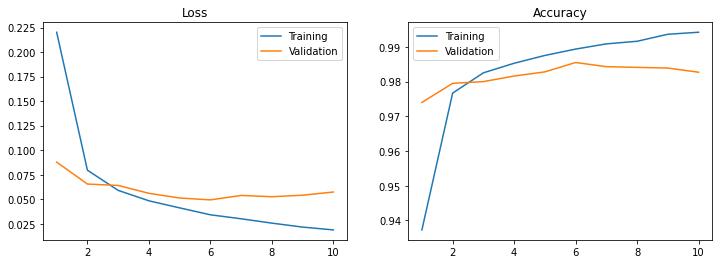

In [ ]:
def plot_loss_acc(history, epoch):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    
    fig, axes = plt.subplots(1,2, figsize=(12,4))

    axes[0].plot(range(1, epoch+1), loss, label='Training')
    axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch+1), acc, label='Training')
    axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 10)

#### **2-3** 모델 구조 파악

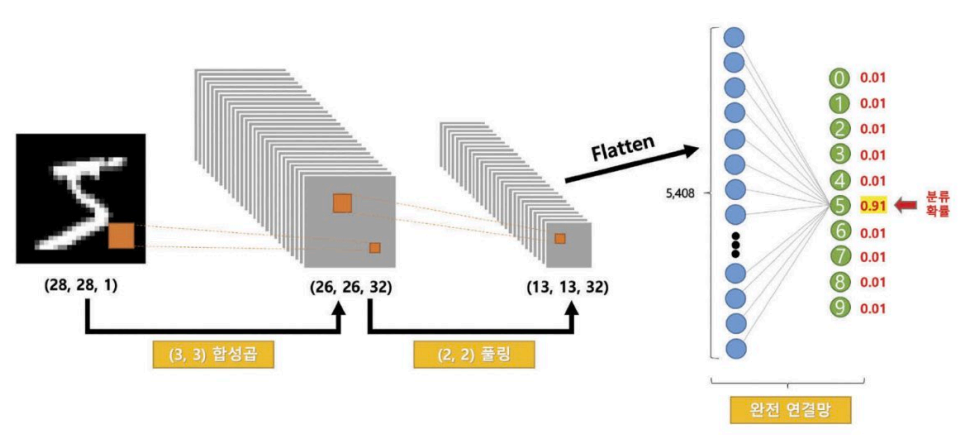

In [ ]:
# 모델 구조
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 26, 26, 32)        320       
                                                                 
 pool (MaxPooling2D)         (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 입력 텐서 형태
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [ ]:
# 출력 텐서 형태
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

In [ ]:
# 레이어
model.layers

In [ ]:
# 첫 번째 레이어 선택
model.layers[0]

In [ ]:
# 첫 번째 레이어 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [ ]:
# 첫 번째 레이어 출력
model.layers[0].output

<KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'conv')>

* (28,28,1) 형태의 입력 텐서가 Conv2D를 거치면서 (26,26,32)로 변환

In [ ]:
# 첫 번째 레이어 가중치
model.layers[0].weights

[<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-0.6795938 , -0.73771465,  0.1582919 , -0.03306444,
            0.15731055,  0.36370793, -0.39891088, -0.6573708 ,
           -0.6538737 ,  0.20975731, -0.07811709, -0.0162736 ,
           -0.37487423, -0.26271775, -0.83945113,  0.71488804,
            0.14145117, -0.43568072, -1.0112181 , -0.02160898,
           -1.152757  , -0.15807891,  0.1883564 ,  0.38921028,
           -0.1499148 ,  0.52593434, -0.8365282 , -0.8907496 ,
            0.17168835, -0.45609036,  0.3464868 , -0.41623497]],
 
         [[ 0.16256364,  0.09301434, -0.06572445,  0.5271128 ,
            0.3532947 ,  0.38515747, -0.16382656, -0.2076105 ,
           -0.69714296, -0.18936653, -0.530946  ,  0.65134686,
           -0.13564573,  0.12275597,  0.05013725,  0.67659986,
            0.47723642, -0.6542931 , -0.84142184,  0.01745252,
           -0.59034026,  0.37775144,  0.2873505 ,  0.19175492,
           -0.06663466,  0.06722178, -0.59

In [ ]:
# 첫 번째 레이어 커널 가중치
model.layers[0].kernel

<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[-0.6795938 , -0.73771465,  0.1582919 , -0.03306444,
           0.15731055,  0.36370793, -0.39891088, -0.6573708 ,
          -0.6538737 ,  0.20975731, -0.07811709, -0.0162736 ,
          -0.37487423, -0.26271775, -0.83945113,  0.71488804,
           0.14145117, -0.43568072, -1.0112181 , -0.02160898,
          -1.152757  , -0.15807891,  0.1883564 ,  0.38921028,
          -0.1499148 ,  0.52593434, -0.8365282 , -0.8907496 ,
           0.17168835, -0.45609036,  0.3464868 , -0.41623497]],

        [[ 0.16256364,  0.09301434, -0.06572445,  0.5271128 ,
           0.3532947 ,  0.38515747, -0.16382656, -0.2076105 ,
          -0.69714296, -0.18936653, -0.530946  ,  0.65134686,
          -0.13564573,  0.12275597,  0.05013725,  0.67659986,
           0.47723642, -0.6542931 , -0.84142184,  0.01745252,
          -0.59034026,  0.37775144,  0.2873505 ,  0.19175492,
          -0.06663466,  0.06722178, -0.59889936,  0.050844

In [ ]:
# 첫 번째 레이어 bias 가중치
model.layers[0].bias

<tf.Variable 'conv/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.24439006, -0.13615604, -0.33467466, -0.01864953, -0.26624382,
       -0.46457344,  0.00096194, -0.23590578, -0.11003053, -0.22917968,
        0.20707409, -0.06018836, -0.15035413, -0.23410456, -0.04489392,
        0.00548243, -0.07307657, -0.05986646,  0.15070991, -0.26775804,
       -0.04475437, -0.00713752, -0.09767874, -0.26711482, -0.27365878,
       -0.03865969, -0.12819196, -0.00400494, -0.12791112, -0.16098307,
       -0.42010984, -0.10339601], dtype=float32)>

In [ ]:
# 레이어 이름 사용하여 레이어 선택
model.get_layer('conv')

In [ ]:
# 샘플 이미지의 레이어별 출력을 리스트에 추가(첫 번째, 두 번째 레이어)
activator = tf.keras.Model(inputs=model.input,
                           outputs=[layer.output for layer in model.layers[:2]])
activations = activator.predict(x_train_in[0][tf.newaxis, ...])

len(activations)

2

In [ ]:
# 첫 번째 레이어(conv) 출력층
conv_activation = activations[0]
conv_activation.shape

(1, 26, 26, 32)

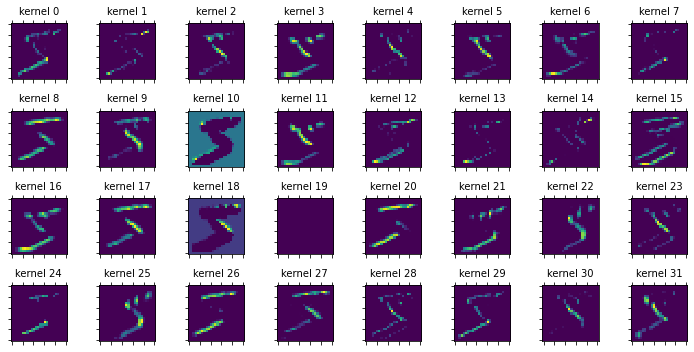

In [ ]:
# convolution 시각화
fig, axes = plt.subplots(4,8)
fig.set_size_inches(10,5)

for i in range(32):
    axes[i//8, i%8].matshow(conv_activation[0,:,:,i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
    plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

In [ ]:
# 두 번째 레이어(pool) 출력층
pooling_activation = activations[1]
print(pooling_activation.shape)

(1, 13, 13, 32)


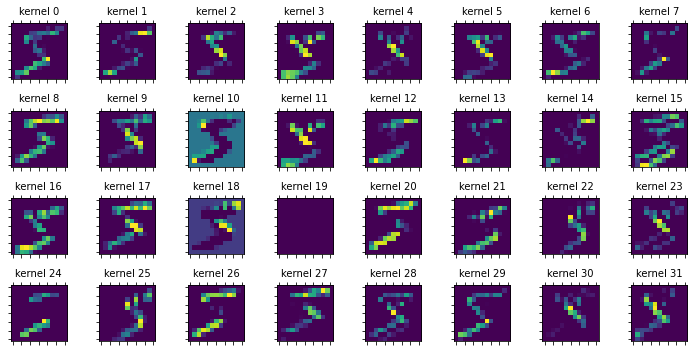

In [ ]:
# 시각화
fig, axes = plt.subplots(4,8)
fig.set_size_inches(10,5)

for i in range(32):
    axes[i//8, i%8].matshow(pooling_activation[0,:,:,i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
    plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

### **03 복잡한 모델 생성**

#### **3-1** 데이터셋 준비

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
# mnist 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


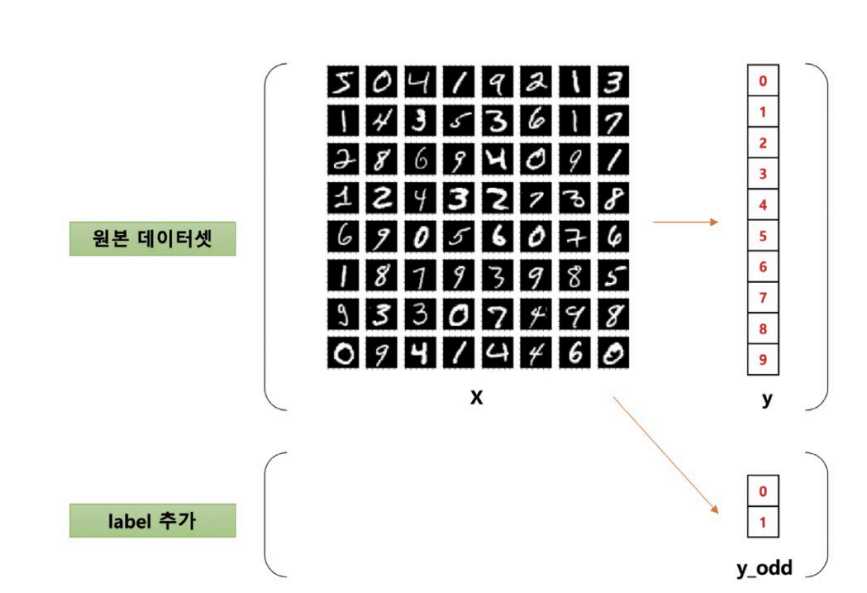

In [ ]:
# 새로운 출력 값 배열 생성(홀수:1, 짝수:0)
y_train_odd = []
for y in y_train:
    if y % 2 ==0:
        y_train_odd.append(0)
    else:
        y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [ ]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


In [ ]:
# validation 데이터셋 처리
y_valid_odd = []
for y in y_valid:
    if y % 2 ==0:
        y_valid_odd.append(0)
    else:
        y_valid_odd.append(1)

y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

In [ ]:
# 정규화
x_train = x_train / 255.0
x_valid = x_valid / 255.0

# 채널 추가
x_train_in = tf.expand_dims(x_train, -1)
x_valid_in = tf.expand_dims(x_valid, -1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


#### **3-2** Functional API로 다중 입력, 다중 출력 레이어 생성

In [ ]:
# Functional API를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28,28,1))

conv = tf.keras.layers.Conv2D(32,(3,3), activation='relu')(inputs)
pool = tf.keras.layers.MaxPooling2D((2,2))(conv)
flat = tf.keras.layers.Flatten()(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
outputs = tf.keras.layers.Dense(10, activation='softmax')(concat)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 flatten_1 (Flatten)            (None, 5408)         0           ['max_pooling2d[0][0]']          
                                                                                            

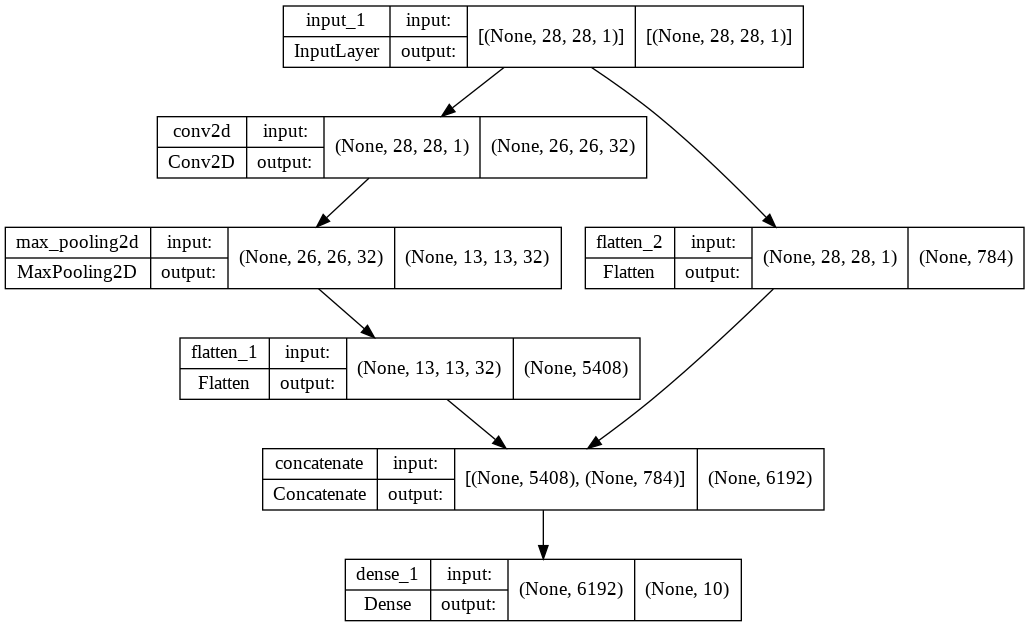

In [ ]:
# 모델 구조 출력 및 이미지 파일로 저장
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train,
                    validation_data = (x_valid_in, y_valid),
                    epochs=10)

# 모델 성능
val_loss, val_acc = model.evaluate(x_valid_in, y_valid)
print(val_loss, val_acc)

Epoch 1/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.2090 - accuracy: 0.9403 - val_loss: 0.0904 - val_accuracy: 0.9724
Epoch 2/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0833 - accuracy: 0.9757 - val_loss: 0.0674 - val_accuracy: 0.9773
Epoch 3/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0638 - accuracy: 0.9808 - val_loss: 0.0646 - val_accuracy: 0.9795
Epoch 4/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0522 - accuracy: 0.9843 - val_loss: 0.0610 - val_accuracy: 0.9804
Epoch 5/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0443 - accuracy: 0.9865 - val_loss: 0.0592 - val_accuracy: 0.9807
Epoch 6/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0367 - accuracy: 0.9890 - val_loss: 0.0604 - val_accuracy: 0.9805
Epoch 7/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0308 - accuracy: 0.9906 - val_loss: 0.0683 -

#### **3-3** 다중 출력 분류 모델

두 가지 서로 다른 분류 문제 예측
* 0~9 숫자 맞추는 분류
* 홀, 짝 맞추는 분류

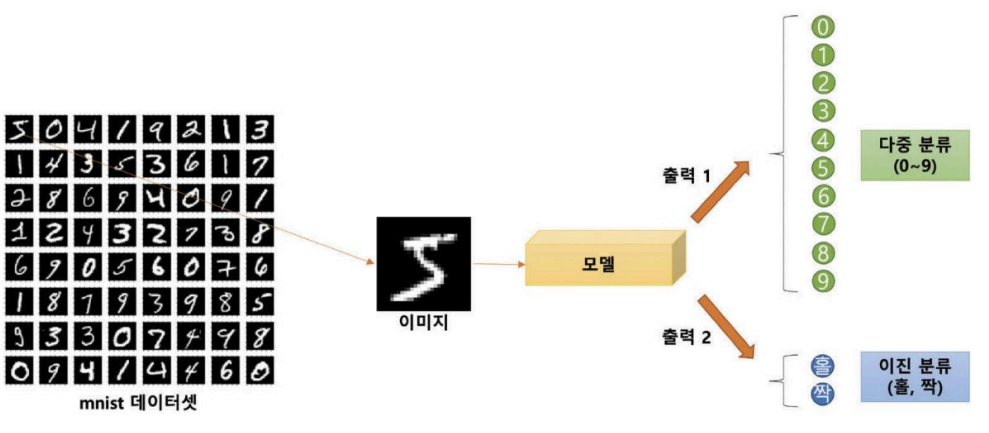

In [ ]:
# Functional API를 사용해 모델 생성

inputs = tf.keras.layers.Input(shape=(28,28,1), name='inputs')

conv = tf.keras.layers.Conv2D(32,(3,3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPooling2D((2,2), name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat)

odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)

model = tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_layer (Conv2D)          (None, 26, 26, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 maxpool_layer (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d_layer[0][0]']           
                                                                                                  
 flatten_layer (Flatten)        (None, 5408)         0           ['maxpool_layer[0][0]']          
                                                                                            

In [ ]:
# 모델의 입력과 출력을 나타내는 텐서
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]


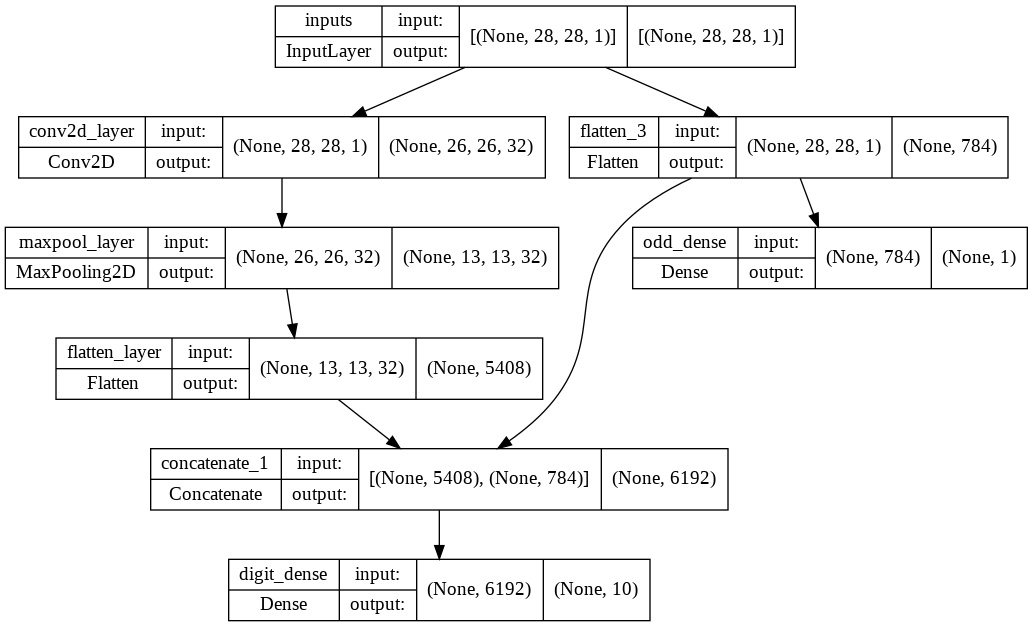

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss={'digit_dense':'sparse_categorical_crossentropy',
                                      'odd_dense':'binary_crossentropy'},
              loss_weights={'digit_dense':1, 'odd_dense':0.5},
              # loss = 1.0, *sparse_categorical_crossentropy + 0.5 * binary_crossentropy
              metrics=['accuracy'])

# 모델 훈련
history = model.fit({'inputs':x_train_in}, {'digit_dense':y_train, 'odd_dense':y_train_odd},
                    validation_data=({'inputs':x_valid_in}, {'digit_dense':y_valid,
                                                             'odd_dense':y_valid_odd}), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.3586 - digit_dense_loss: 0.1952 - odd_dense_loss: 0.3268 - digit_dense_accuracy: 0.9453 - odd_dense_accuracy: 0.8626 - val_loss: 0.2220 - val_digit_dense_loss: 0.0841 - val_odd_dense_loss: 0.2759 - val_digit_dense_accuracy: 0.9752 - val_odd_dense_accuracy: 0.8882
Epoch 2/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.2130 - digit_dense_loss: 0.0770 - odd_dense_loss: 0.2719 - digit_dense_accuracy: 0.9774 - odd_dense_accuracy: 0.8906 - val_loss: 0.1967 - val_digit_dense_loss: 0.0649 - val_odd_dense_loss: 0.2635 - val_digit_dense_accuracy: 0.9789 - val_odd_dense_accuracy: 0.8966
Epoch 3/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.1904 - digit_dense_loss: 0.0589 - odd_dense_loss: 0.2628 - digit_dense_accuracy: 0.9818 - odd_dense_accuracy: 0.8956 - val_loss: 0.1864 - val_digit_dense_loss: 0.0558 - val_odd_dense_loss: 0.2611 - val_digit_dense_accuracy: 0.9821 -

In [ ]:
# 모델 성능
model.evaluate({'inputs':x_valid_in},{'digit_dense':y_valid,'odd_dense':y_valid_odd})

313/313 [==============================] - 2s 8ms/step - loss: 0.1910 - digit_dense_loss: 0.0630 - odd_dense_loss: 0.2559 - digit_dense_accuracy: 0.9830 - odd_dense_accuracy: 0.9014


[0.19099533557891846,
 0.0630321204662323,
 0.2559262812137604,
 0.9829999804496765,
 0.9014000296592712]

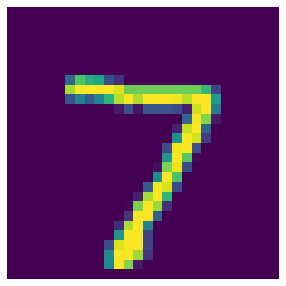

In [ ]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5,5))
    plt.imshow(data[idx])
    plt.axis('off')
    plt.show()

plot_image(x_valid, 0)

In [ ]:
digit_preds, odd_preds = model.predict(x_valid_in)
print(digit_preds[0])
print(odd_preds[0])

[5.6200931e-13 1.4304975e-09 2.2017299e-09 5.3877557e-06 9.7826374e-12
 2.0465509e-12 8.1028181e-21 9.9999464e-01 2.6707211e-10 7.8700628e-09]
[0.9995475]


In [ ]:
digit_labels = np.argmax(digit_preds, axis=1)
digit_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [ ]:
odd_labels=(odd_preds > 0.5).astype(np.int).reshape(1,-1)[0]
odd_labels[0:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1])

#### **3-4** 전이 학습(Transfer Learning)

기존에 학습된 모델을 활용해 새로운 모델을 만들어 내는 개념

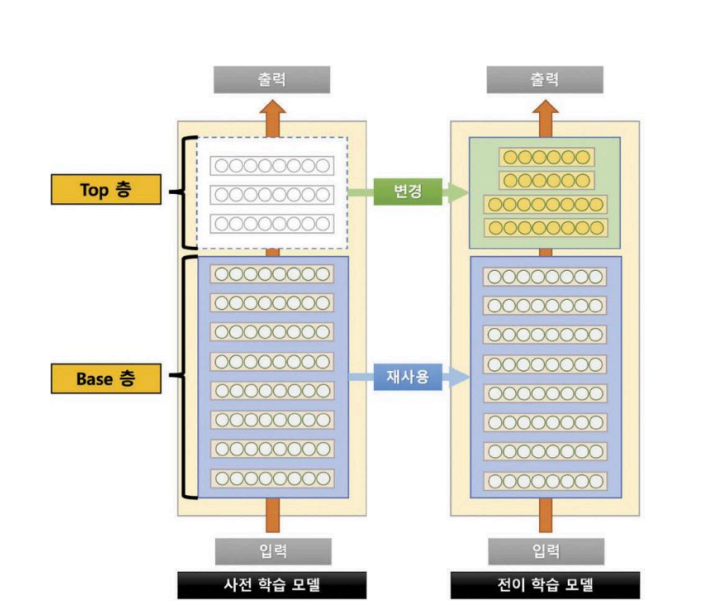

In [ ]:
# 앞의 모델에서 flatten_layer 출력을 추출
base_model_output = model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


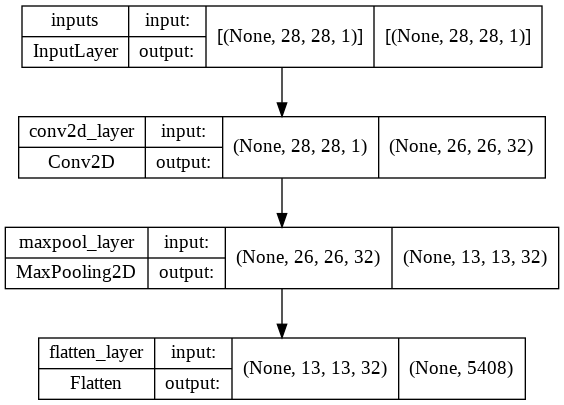

In [ ]:
plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

In [ ]:
# Sequential API 적용
digit_model = tf.keras.Sequential([
                                   base_model,
                                   tf.keras.layers.Dense(10, activation='softmax'),
])
digit_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 5408)              320       
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


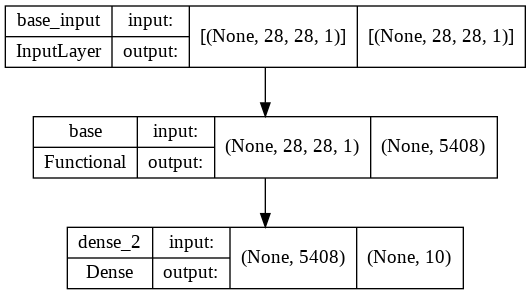

In [ ]:
plot_model(digit_model, show_shapes=True, show_layer_names=True, to_file='digit_model.png')

In [ ]:
# 모델 컴파일
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# 모델 훈련
history = digit_model.fit(x_train_in, y_train,
                          validation_data=(x_valid_in, y_valid),
                          epochs=10)

Epoch 1/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1310 - accuracy: 0.9636 - val_loss: 0.0669 - val_accuracy: 0.9784
Epoch 2/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0587 - accuracy: 0.9827 - val_loss: 0.0583 - val_accuracy: 0.9812
Epoch 3/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0451 - accuracy: 0.9865 - val_loss: 0.0486 - val_accuracy: 0.9845
Epoch 4/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0368 - accuracy: 0.9886 - val_loss: 0.0543 - val_accuracy: 0.9825
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0298 - accuracy: 0.9910 - val_loss: 0.0598 - val_accuracy: 0.9808
Epoch 6/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.0500 - val_accuracy: 0.9847
Epoch 7/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0208 - accuracy: 0.9931 - val_loss: 0.0501 -

In [ ]:
# 베이스 모델의 가중치 고정(Freeze Model)

base_model_frozen = tf.keras.models.Model(inputs=model.input,
                                          outputs=base_model_output,
                                          name='base_frozen')
base_model_frozen.trainable = False
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


* 총 파라미터 개수는 54,410, 고정한 320개의 파라미터는 훈련이 불가능
* 훈련 가능한 파라미터는 Flatten 레이어의 출력 5,408개와 Dense레이어의 10개 노드 사이의 가중치만 해당. = Flatten 레이어 이전에 존재하는 Conv2D 레이어의 파라미터 320개는 미포함.

In [ ]:
# Functional API 적용
dense_output = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = tf.keras.models.Model(inputs=base_model_frozen.input,
                                           outputs=dense_output)
digit_model_frozen.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

In [ ]:
# 모델 컴파일
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen.fit(x_train_in, y_train,
                                 validation_data=(x_valid_in, y_valid),
                                 epochs=10)

Epoch 1/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1160 - accuracy: 0.9693 - val_loss: 0.0627 - val_accuracy: 0.9803
Epoch 2/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0489 - accuracy: 0.9852 - val_loss: 0.0611 - val_accuracy: 0.9811
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0363 - accuracy: 0.9891 - val_loss: 0.0524 - val_accuracy: 0.9827
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0279 - accuracy: 0.9918 - val_loss: 0.0514 - val_accuracy: 0.9836
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0224 - accuracy: 0.9937 - val_loss: 0.0503 - val_accuracy: 0.9850
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0185 - accuracy: 0.9946 - val_loss: 0.0511 - val_accuracy: 0.9851
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0152 - accuracy: 0.9955 - val_loss: 0.0516 - val_ac

In [ ]:
# 베이스 모델의 Conv2D 레이어의 가중치만 고정(Freeze Layer)
base_model_frozen2 = tf.keras.models.Model(inputs=model.input,
                                           outputs=base_model_output,
                                           name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable = False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [ ]:
# Functional APi 적용
dense_output2 = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2 = tf.keras.models.Model(inputs=base_model_frozen2.input,
                                            outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

In [ ]:
# 모델 컴파일
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen2.fit(x_train_in, y_train,
                                  validation_data=(x_valid_in, y_valid),
                                  epochs=10)

Epoch 1/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1143 - accuracy: 0.9691 - val_loss: 0.0560 - val_accuracy: 0.9823
Epoch 2/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0482 - accuracy: 0.9862 - val_loss: 0.0484 - val_accuracy: 0.9845
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0359 - accuracy: 0.9893 - val_loss: 0.0499 - val_accuracy: 0.9838
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0280 - accuracy: 0.9915 - val_loss: 0.0494 - val_accuracy: 0.9834
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0226 - accuracy: 0.9930 - val_loss: 0.0562 - val_accuracy: 0.9833
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0181 - accuracy: 0.9945 - val_loss: 0.0516 - val_accuracy: 0.9838
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0561 - val_ac